In [153]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('fivethirtyeight')


# 1, Load data 

In [154]:
# Import data
df = yf.download('MSFT', start='2002-06-03', end='2023-04-16')

# Show data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-06-03,25.495001,25.820000,24.584999,24.709999,15.416524,88439000
2002-06-04,24.750000,25.615000,24.620001,24.990000,15.591218,88008400
2002-06-05,25.215000,25.875000,25.165001,25.830000,16.115297,66969400
2002-06-06,25.750000,26.070000,25.000000,25.950001,16.190157,78703400
2002-06-07,24.945000,26.299999,24.930000,25.990000,16.215115,97834400
...,...,...,...,...,...,...
2023-04-10,289.209991,289.600006,284.709991,289.390015,289.390015,23103000
2023-04-11,285.750000,285.980011,281.640015,282.829987,282.829987,27276600
2023-04-12,284.790009,287.010010,281.959991,283.489990,283.489990,27403400


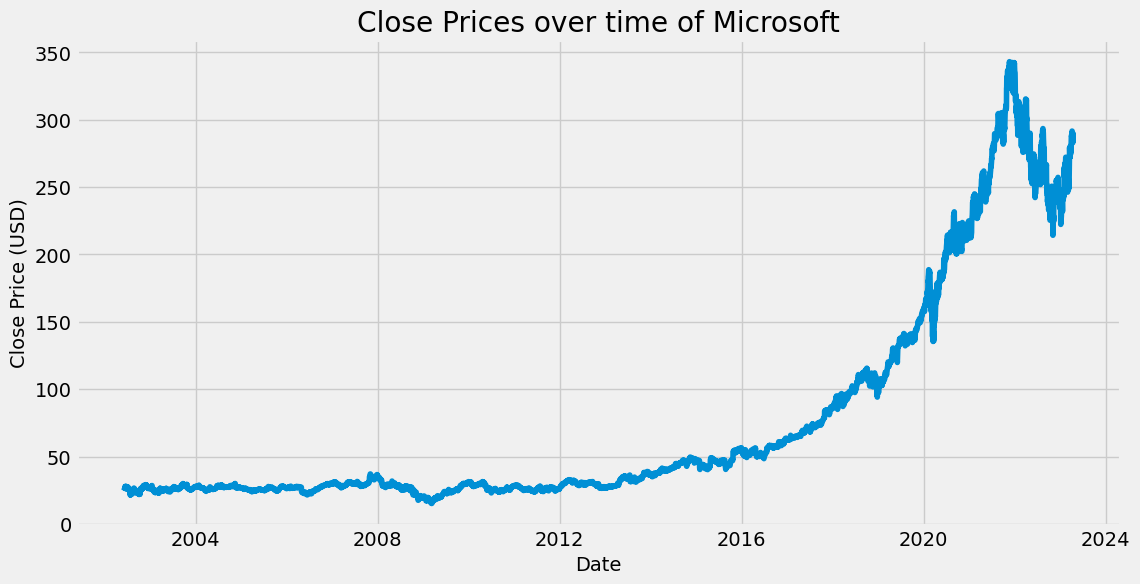

In [155]:
## Visualize the closing price history

# Draw data on the chart . X - date, Y - close price
plt.plot(df.index, df['Close'])

# Set size for the chart
plt.gcf().set_size_inches(12, 6)

# set the title and axis labels
plt.title('Close Prices over time of Microsoft')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')

# show the plot
plt.show()

# 2, Prepare data to train

In [156]:
#create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#convert the dataframe to a numpy array
dataset = data.values

#get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8) # Train 80% of the data 

training_data_len

4204

In [157]:
## Scale the data
scaler = MinMaxScaler(feature_range=(0,1)) # Range of values data only between 0 and 1
scaled_data = scaler.fit_transform(dataset) # method to scale the data 

# Example: [10, 20, 30, 35, 40, 90]
# After scaling with:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data) ?
# => Output :  [0  0.11111111  0.22222222  0.27777778  0.33333333  1 ]


scaled_data 

array([[0.0291499 ],
       [0.03000366],
       [0.03256495],
       ...,
       [0.81820954],
       [0.83757168],
       [0.82628987]])

In [158]:
## create the training dataset

#Create the scaled training data set based on the scaled data in the previous step
train_data = scaled_data[0:training_data_len  , : ] 
# '0:training_data_len'  means that the ROWS from the beginning to the training_data_len are selected
#  ':'  means that ALL COLUMNS are selected.

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0]) # 60 previous i row values in the column index = 0 - column 0 is first column
    y_train.append(train_data[i,0]) # 61st value of the column 0 
    if i<= 61:# print the first 61 values 
        print(x_train)
        print(y_train)
        print()


[array([0.0291499 , 0.03000366, 0.03256495, 0.03293085, 0.03305281,
       0.03433346, 0.03395231, 0.03848031, 0.03646787, 0.03803818,
       0.03869375, 0.03916637, 0.03668131, 0.03628491, 0.03351018,
       0.03637639, 0.03453165, 0.03633065, 0.03753507, 0.03719966,
       0.03408953, 0.03222954, 0.03283937, 0.03742835, 0.03448591,
       0.03492804, 0.03344921, 0.03447067, 0.03286987, 0.03277839,
       0.03193987, 0.03308331, 0.03172643, 0.02936334, 0.02623796,
       0.01937736, 0.0242865 , 0.01910294, 0.02294487, 0.02736614,
       0.02713746, 0.02695451, 0.0235547 , 0.02151177, 0.02087145,
       0.02343274, 0.02559764, 0.02837236, 0.02716795, 0.02770155,
       0.0255519 , 0.02959202, 0.0296835 , 0.03003415, 0.03308331,
       0.03161971, 0.03351018, 0.03495853, 0.03341871, 0.03323576])]
[0.03131479724518501]

[array([0.0291499 , 0.03000366, 0.03256495, 0.03293085, 0.03305281,
       0.03433346, 0.03395231, 0.03848031, 0.03646787, 0.03803818,
       0.03869375, 0.03916637, 0.03

### Note :Build model predicts price based on last 60 days so create training dataset into parts, each part contains 60 values


In [159]:
# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [160]:
# Reshape the data because LSTM model in 3 dimensions but numpy array in 2 dimensions
# Convert numpy array => 3 Dimensions array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
#x_train.shape[0] = 4144 , x_train.shape[1] = 60 , 1 is the number of features ( only have 1 feature = 'Close')

x_train.shape

(4144, 60, 1)

# 3, Build and train the model

## Task a : Build the model

In [161]:
## Build the LSTM model

### What is LSTM?
# The LSTM layer is a type of recurrent neural network (RNN) layer that is commonly used for sequence processing tasks, 
# such as time series prediction, speech recognition, and natural language processing.
# The LSTM layer is capable of capturing long-term dependencies in the input sequence 
# by allowing information to be retained or forgotten over time. 
# This is achieved through the use of "MEMORY CELLS" and "GATES", 
# which control the flow of information through the layer.

# Example :
# model = Sequential()
# model.add(LSTM(64, input_shape=(10, 1))) # LSTM layer with 64 memory cells
# model.add(Dense(1, activation='sigmoid')) # Output layer with 1 neuron
# Explain:
# The LSTM layer is configured to have 64 MEMORY CELLS and an input shape of (10, 1), 
# which means it will take in a sequence of 10 time steps, each with 1 feature. 
# Finally, we add a dense OUTPUT layer with 1 neuron and a sigmoid activation function.


#  Create the model
model = Sequential()  
#the Sequential class is used to define a linear stack of layers that make up a deep learning model. 
#It is a wrapper for the neural network model that provides an easy-to-use interface for creating and managing models.

# Add the first LSTM layer 
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1))) 
# 50 neurons, return_sequences = True because we have more than one LSTM layer
# input_shape is the time step, x_train.shape[1] = 60 is the number of features, repeat 1 time

# Add the second LSTM layer
model.add(LSTM(50, return_sequences=False)) 
# 50 neurons, return_sequences = False because that layer returns only the last output in the output sequence

# Add the third, four layer 
model.add(Dense(25)) # 25 neurons
# The dense layer receives input from the previous layer 
# and applies a linear transformation to produce a new set of outputs.

model.add(Dense(1)) # 1 neuron
# This adds a final dense layer with 1 neuron. 
# This is the output layer of the model, which produces a single continuous output value


In [162]:

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# compile() function is used to configure the learning process of a model
# It takes three main arguments: optimizer, loss, and metrics.

# optimizer is the optimization algorithm used during training
# 'adam' optimizer is a popular choice in deep learning 
# because it adapts the learning rate during training and works well for many problems.
# during training, the model will use the 'adam' algorithm to optimize the weights and biases

# loss argument is used to specify the loss function that the model will minimize during training. 
# The 'mean_squared_error' loss function is a common choice for regression problems, 
# the goal is to minimize the mean squared error between the predicted and actual values.


## Task b: Train the model

In [163]:
## Train the model
model.fit(x_train, y_train, batch_size=1, epochs=4)

# model.fit() is a method trains the neural network model with the specified input data (x_train) and target data (y_train). 
# The training process involves updating the weights and biases of the model based on the input data and the output produced by the model.
# x_train: The input data used for training the model.
# y_train: The target data used for training the model.
# batch_size: The number of samples processed before the model is updated
# example: Initially the data has 120 rows, 
# batch_size=3 => You will be tranning the first 40 rows, batch_size = 2 => 60 rows
# epochs: The number of times the model is trained on the entire dataset. 
# An epoch is considered complete when the model has processed all of the training data once.

Epoch 1/4
4144/4144 [==============================] - 230s 53ms/step - loss: 9.3487e-05
Epoch 2/4
4144/4144 [==============================] - 221s 53ms/step - loss: 4.0853e-05
Epoch 3/4
4144/4144 [==============================] - 225s 54ms/step - loss: 3.5425e-05
Epoch 4/4
4144/4144 [==============================] - 222s 54ms/step - loss: 2.4539e-05


In [164]:
# create the testing data set

# Create a new array containing scaled values from index 4144( the train data shape[0]) to 5254 ( end)
test_data = scaled_data[training_data_len - 60: , : ]
# 'training_data_len - 60 : '  means that the ROWS from the training_data_len - 60 to end are selected
#  ':'  means that ALL COLUMNS are selected.

# Create the data sets x_test and y_test
x_test = []
y_test =  dataset[training_data_len : , : ]

# Add value for x_test
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0]) 
    # 60 previous i row values in the column index = '0' - column 0 is first column


In [165]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [166]:
# Reshape the numpy array to 3 dimensions
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
# 1 is the number of features ( only have 1 feature = 'Close')

In [167]:
# Get the models predicted price values

# Predict the values
predictions = model.predict(x_test) 
# predict() function is used to predict the output for the input samples based on the trained model.

# Unscale the data
predictions = scaler.inverse_transform(predictions) 

33/33 [==============================] - 6s 45ms/step


# 4, Backtesting the model

In [168]:
## Checking the average deviation between the predicted values and the actual values

# Get the root mean squared error (RMSE)
# RMSE  is a measure of the average deviation between the predicted values and the actual values in a dataset. 
# It is a commonly used evaluation metric in regression analysis, machine learning and other predictive modeling tasks.
# Fomula: RMSE = sqrt(mean((y_pred - y_true)^2))
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8.43848429428632

### The 2 way to reduce average deviation 
### Method 1: is to increase the trained data - is increase 'tranning_data_len' in part Prepare data
### Method 2: train the data many times - is increase 'epochs'  in  ' model.fit(x_train, y_train, batch_size=1, epochs=2)'
### Method 1 helps to reduce deviation much more method 2 
## => WE NEED BIG DATA



C:\Users\Long\AppData\Local\Temp\ipykernel_2328\4154377626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predictions


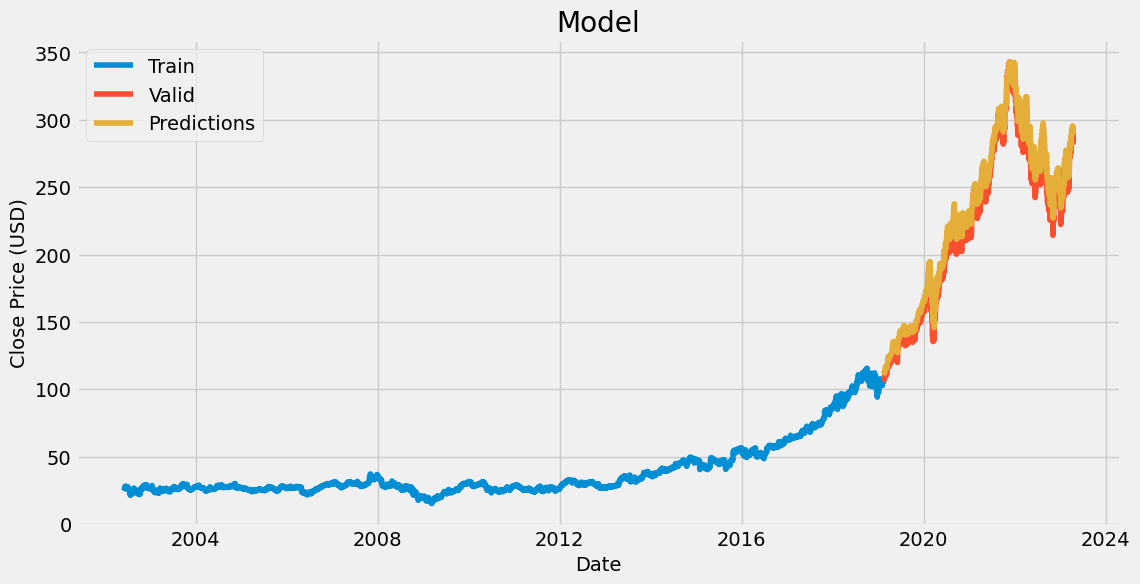

In [169]:
## Visualize the data

# Create the data for the graph
train_data = data[:training_data_len] # Trained data
valid_data = data[training_data_len:] # Valid_data use to valid the trained data
valid_data['Predictions'] = predictions

# Draw the line chart with X- axis is Date, Y- axis is Close Price of the train data 
plt.plot(train_data['Close'])

# Draw the line chart with X- axis is Date, Y- axis is Close Price and Predict Price of the Predict data 
plt.plot(valid_data[['Close', 'Predictions']])

# Set size for the chart
plt.gcf().set_size_inches(12, 6)

# Set title for the chart
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left') 

plt.show()


In [170]:
# Show the valid and predicted prices
valid_data

,Close,Predictions
Date,,
2019-02-13,106.809998,111.287399
2019-02-14,106.900002,111.506325
2019-02-15,108.220001,111.573524
2019-02-19,108.169998,112.586830
2019-02-20,107.150002,112.762177
...,...,...
2023-04-10,289.390015,295.485413
2023-04-11,282.829987,294.898590
2023-04-12,283.489990,290.194885


# 5, Predict price for a specific day

In [171]:
## Example: Predict the price of MSFT on 2023-04-12

# Import data 
df_new = yf.download('MSFT', start='2002-06-03', end='2023-04-12')
#create a new dataframe only with the 'Close' column
new_data = df_new.filter(['Close'])
# Get the last 60 day closing price values and convert the dataframe to an numpy array
last_60_days = new_data[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an test list
X_test = []
# Add Close Price last 60 days to the test list
X_test.append(last_60_days_scaled)
# Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
# Reshape the data => 3 dimensions array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price) # Print the predicted price

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 67ms/step
[[290.19485]]


In [173]:
# Check the real price
df_new2 = yf.download('MSFT', start='2023-04-13', end='2023-04-14')
print(df_new2['Close'])

[*********************100%***********************]  1 of 1 completed
Date
2023-04-13    289.839996
Name: Close, dtype: float64
